# Evaluation in terms of spherical harmonics
This notebook contains the computation necessary to transform mascon models and geodesyNETs model into normalized Stokes coefficients. We use the following formal definition for the description of the gravitational potential (Tricarico 2013, Yoder 1995):

$$
U(r, \theta, \phi) = \frac \mu r \sum_{l=0}^{l=\infty}\sum_{m=0}^{m=l}\left(\frac {r_0}r\right)P_{lm}(cos\theta) \cdot\\
\cdot \left( C_{lm}\cos m\phi + S_{lm} \sin m\phi \right)
$$

where the Stokes coefficients relate to the body density via the formulas:


and

$$
C_{lm} = \frac{(2-\delta_{m,0})}{M}\frac{(l-m)!}{(l+m)!} \int_V \rho \left(\frac{r}{r_0} \right)^l \cdot\\
\cdot P_{lm}(\cos\theta)\cos m\phi dV
$$

and

$$
S_{lm} = \frac{(2-\delta_{m,0})}{M}\frac{(l-m)!}{(l+m)!} \int_V \rho \left(\frac{r}{r_0} \right)^l \cdot\\
\cdot P_{lm}(\cos\theta)\sin m\phi dV
$$

We also use the normalization factor $N_{lm}$ defined as:

$$
N_{lm} = \sqrt{\frac{(l+m)!}{(2-\delta_{m,0})(2l+1)(l-m)!} }
$$

so that our normalized Stokes coefficients are $\left\{\tilde C_{m,l}, \tilde
S_{m,l}\right\} = \left\{C_{m,l}, S_{m,l}\right\} N_{lm}$


In [1]:
# Import our module containing helper functions
import gravann

# Core imports
import numpy as np
import scipy
import pickle as pk
import os
from collections import deque

# pytorch
from torch import nn
import torch

# plotting stuff
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib notebook

# Ensure that changes in imported module (gravann most importantly) are autoreloaded
%load_ext autoreload
%autoreload 2

# If possible enable CUDA
gravann.enableCUDA()
gravann.fixRandomSeeds()
device = os.environ["TORCH_DEVICE"]
print("Will use device ",device)

/home/dario/.local/lib/python3.8/site-packages/pyvista/themes.py:123: PyvistaDeprecationWarning: use "dark" instead of "night" theme
  warnings.warn('use "dark" instead of "night" theme', PyvistaDeprecationWarning)


Will use device  cpu


/home/dario/Develop/anns4geodesy/gravann/_utils.py:80: UserWarning: Error enabling CUDA. cuda.is_available() returned False. CPU will be used.
  warnings.warn(


# Loading and visualizing the ground truth asteroid (a point cloud)

In [2]:
# We load the ground truth (a mascon model of some body)
with open("mascons/Eros.pk", "rb") as file:
    mascon_points, mascon_masses, mascon_name = pk.load(file)
    
mascon_points = mascon_points
mascon_masses = mascon_masses

# Print some information on the loaded ground truth 
# (non-dimensional units assumed. All mascon coordinates are thus in -1,1 and the mass is 1)
print("Name: ", mascon_name)
print("Number of mascons: ", len(mascon_points))
print("Total mass: ", sum(mascon_masses))

Name:  Eros
Number of mascons:  39554
Total mass:  1.0000000000000102


<IPython.core.display.Javascript object>


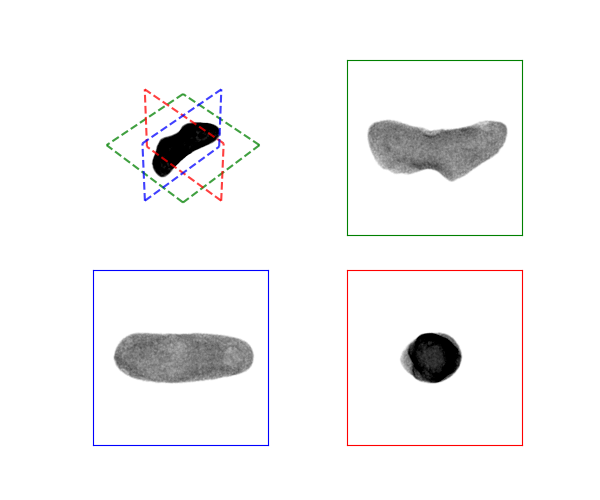

In [3]:
# Here we visualize the loaded ground truth
gravann.plot_mascon(mascon_points, mascon_masses)

# Computing the Stokes coefficients


In [57]:
# Units of Length (this is Eros) (depend on how the the mascon model was created .... )
L  = 20413.864850997925
# Units of mass (this is Eros)
M = 6.687*10e5
# Putting dimensions back into the mascon model
mascon_points_dim = (mascon_points)*L
mascon_masses_dim = mascon_masses*M

In [58]:
# Spherical coordinates are here defined as radius, colatitude and longitude (r, theta [0, pi], phi [])
def cart2spherical(x,y,z):
    r = np.sqrt(x**2+y**2+z**2)
    theta = np.arccos(z/r)
    phi = np.arctan2(y,x)
    if phi<0:
        phi = phi+2*np.pi
    return r,theta, phi
def spherical2cart(r, theta, phi):
    x = r*np.sin(theta)*np.cos(phi)
    y = r*np.sin(theta)*np.sin(phi)
    z = r*np.cos(theta)
    return x,y,z

In [59]:
# Reference diameter for Eros (mean equatorial radius)
R0 = 16000
def single_mascon_contribution(mascon_point, mascon_mass, R0, l, m):
    x,y,z = mascon_point
    r, theta,phi = cart2spherical(x,y,z)
    retval = mascon_mass
    retval *= (r/R0)**l
    retval *= np.cos(m*phi)
    retval *= scipy.special.lpmn(m, l, np.cos(theta))[0][-1][-1]
    return retval

In [60]:
acc = 0 
l = 1
m = 0
if m==0:
    delta=1
else:
    delta=0
normalized = np.sqrt(np.math.factorial(l+m) / (2-delta)/(2*l+1)/np.math.factorial(l-m))

coeff = (2-delta)/M*np.math.factorial(l-m)/np.math.factorial(l+m)
for point, mass in zip(mascon_points_dim,mascon_masses_dim):
    acc+= single_mascon_contribution(point, mass, R0, l, m)
acc*=coeff

In [61]:
acc*normalized

array([-1.14950244e-18])

In [219]:
coeff

1.4954389113204726e-07

In [40]:
scipy.special.lpmn(0, 1, np.cos(0.3))

(array([[1.        , 0.95533649]]), array([[0., 1.]]))

In [42]:
np.cos(0.3)

0.955336489125606

In [51]:
np.sum((mascon_points+0.1)*mascon_masses, axis=0)

array([0.1, 0.1, 0.1])